# **Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy as np
from PIL import Image
import itertools
import pandas as pd
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
with open('/content/drive/My Drive/Facebook_Data_Bruno_Leme/favorite music.txt', 'rb') as file:
    dict_friends_favorite_music = json.loads(file.read())

# **Data Prep**

In [ ]:
def item_list(str_items):
  music = ''
  music_list = []
  flg_quote = False
  for c in str_items:
    if c == '"':
      flg_quote = not flg_quote
    if c == ',' and not flg_quote:
      music_list.append(music.strip())
      music = ''
    else:
      music += c
  music_list.append(music.strip()) #last element
  return music_list

In [ ]:
dict_all_friend = {}
for f in dict_friends_favorite_music['data']:
  dict_friend = dict(f)
  uid = dict_friend['uid']
  friend_music_list = item_list(dict_friend['music'])
  dict_all_friend[uid] = friend_music_list

In [ ]:
music_list = np.array(np.unique(list(itertools.chain.from_iterable([v for k, v in dict_all_friend.items()])), return_counts=True)).T

In [ ]:
music_list.shape

(7843, 2)

## **Exploratory Data Analysis**

In [ ]:
music_df = pd.DataFrame(music_list, columns=['page', 'count'])
music_df['count'] = music_df['count'].astype(np.int32)
music_df = music_df.sort_values('count', ascending=False).reset_index(drop=True)

In [ ]:
music_df[:80]

,page,count
0,Zeca Pagodinho,129
1,Diogo Nogueira,124
2,Ivete Sangalo,122
3,Exaltasamba,116
4,Arlindo Cruz,111
...,...,...
75,Marvin Gaye,37
76,Glamour da Batucada,37
77,The Rolling Stones,37
78,Katy Perry,36


In [ ]:
music_df.iloc[0].values[0]

'Zeca Pagodinho'

In [ ]:
from wordcloud import WordCloud

In [ ]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)
  

mask = np.array(Image.open('/content/drive/My Drive/Facebook_Data_Bruno_Leme/GuitarImage.jpg'))

In [ ]:
page_freq_dict = {m : f for m, f in music_df[:80].values}

In [ ]:
wc = WordCloud(max_words=1000, mask=mask, margin=10, random_state=1).generate_from_frequencies(page_freq_dict)

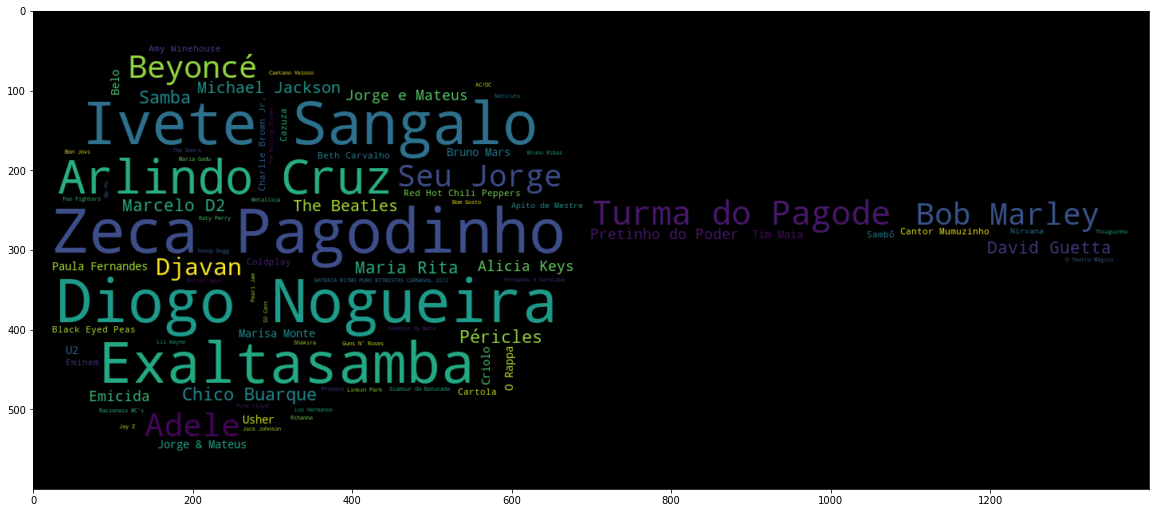

In [ ]:
plt.figure(figsize=(20,10))
default_colors = wc.to_array()
plt.imshow(wc.recolor(random_state=3),interpolation="bilinear")
plt.show()

## **Dataset Creation**

In [ ]:
top_music_list = music_df['page'][:80].values

In [ ]:
uid_map = {k:v for k, v in enumerate(dict_all_friend)}
uid_inv_map = {v:k for k, v in uid_map.items()}
music_map = {k:v for k, v in enumerate(top_music_list)}
music_inv_map = {v:k for k, v in music_map.items()}
music_count = {}

In [ ]:
data = np.zeros((len(uid_inv_map), len(music_inv_map)), np.float64)
for u, m_list in dict_all_friend.items():
  for m in m_list:
    if m not in music_inv_map:
      continue
    data[uid_inv_map[u], music_inv_map[m]] = 1

In [ ]:
df_data = pd.DataFrame(data, columns=np.array([music_map[i] for i in range(max(music_map)+1)]))

In [ ]:
df_data

,Zeca Pagodinho,Diogo Nogueira,Ivete Sangalo,Exaltasamba,Arlindo Cruz,Turma do Pagode,Adele,Beyoncé,Bob Marley,Seu Jorge,Djavan,Chico Buarque,Péricles,Samba,Maria Rita,David Guetta,Marcelo D2,The Beatles,Michael Jackson,Jorge e Mateus,Emicida,Pretinho do Poder,Alicia Keys,Jorge & Mateus,U2,Tim Maia,Paula Fernandes,Marisa Monte,Criolo,O Rappa,Belo,Usher,Bruno Mars,Red Hot Chili Peppers,Sambô,Cartola,Black Eyed Peas,Coldplay,Eminem,Amy Winehouse,Cantor Mumuzinho,Beth Carvalho,Cazuza,Charlie Brown Jr.,Apito de Mestre,Nirvana,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,Thiaguinho,Los Hermanos,AC/DC,Foo Fighters,Guns N' Roses,Pearl Jam,Caetano Veloso,Racionais MC's,Projota,Jack Johnson,Bom Gosto,Jay Z,Lil Wayne,Metallica,The Doors,50 Cent,Bruno Ribas,O Teatro Mágico,Pink Floyd,Linkin Park,Bon Jovi,Vanessa da Mata,Rihanna,Natiruts,Fernando e Sorocaba,Snoop Dogg,Maria Gadu,Shakira,Marvin Gaye,Glamour da Batucada,The Rolling Stones,Katy Perry,Ne-Yo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# **Dimension Reduction**

## **Number of Dimensions Decision**

In [ ]:
svd =  TruncatedSVD(n_components = max(music_map))

In [ ]:
svd.fit(df_data)

TruncatedSVD(algorithm='randomized', n_components=79, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
svd.explained_variance_.round(2)

array([0.67, 0.32, 0.17, 0.15, 0.14, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01])

In [ ]:
svd.explained_variance_ratio_.round(2)

array([0.16, 0.08, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

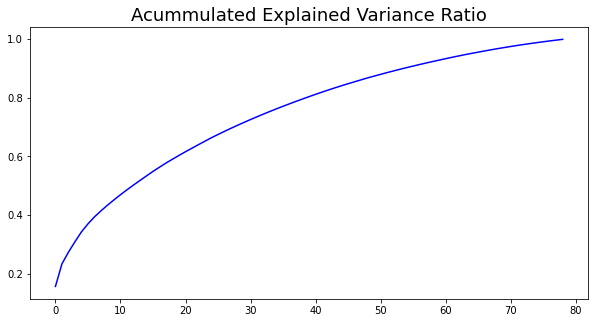

In [ ]:
explained_variance_ratio_acum_ = list([(i-1, svd.explained_variance_ratio_[:i].sum()) for i in range(1, max(music_map)+1)])
plt.figure(figsize=(10,5))
plt.plot([i for i, r in explained_variance_ratio_acum_], [r for i, r in explained_variance_ratio_acum_], 'b')
plt.title('Acummulated Explained Variance Ratio', fontsize=18); 
plt.show()

In [ ]:
pd.DataFrame(explained_variance_ratio_acum_, columns=['variable_index', 'explained_variance_ratio_acum']).head(20)
#12 variables captures 50% of explained variance

,variable_index,explained_variance_ratio_acum
0,0,0.158063
1,1,0.234723
2,2,0.274527
3,3,0.309818
4,4,0.343457
5,5,0.370636
6,6,0.394335
7,7,0.414910
8,8,0.434078
9,9,0.452148


## **Truncated SVD**

In [ ]:
svd =  TruncatedSVD(n_components = 12)
svd.fit(df_data)

TruncatedSVD(algorithm='randomized', n_components=12, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
svd.components_.shape

(12, 80)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
df_data_new = svd.fit_transform(df_data)
df_data_new = scaler.fit_transform(df_data_new)
df_data_new = pd.DataFrame(df_data_new, columns=['Dim' + str(c + 1) for c in range(svd.components_.shape[0])])

### **Users Plot on First 2 Dimensions**

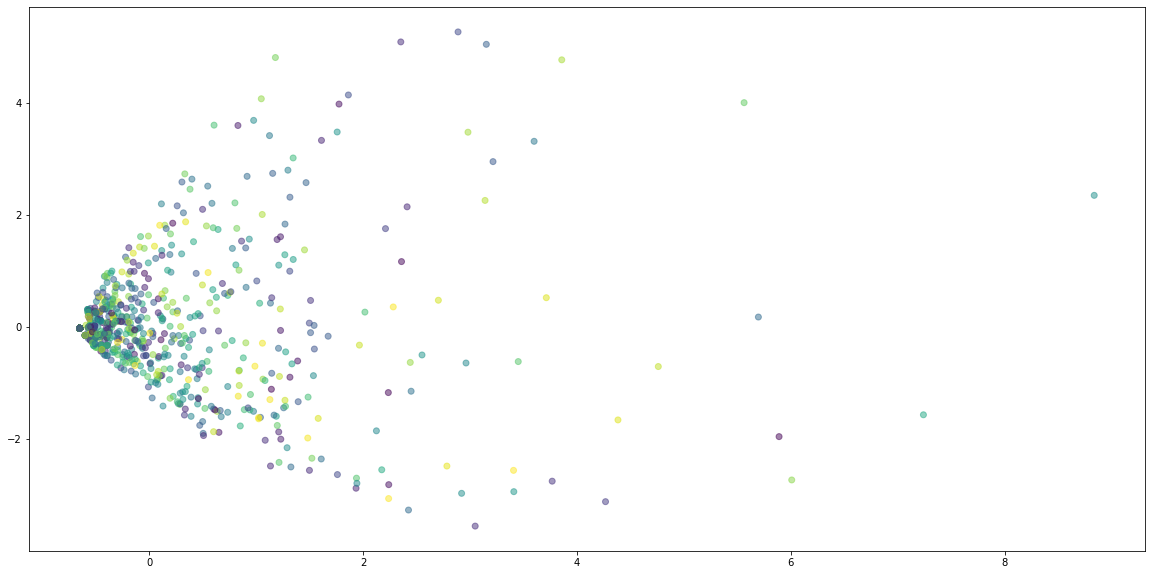

In [ ]:
N = 50
x = df_data_new.Dim1.values
y = df_data_new.Dim2.values
colors = np.random.rand(len(x))

plt.figure(figsize=(20,10))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

### **Music Pages Plot on First 2 Dimensions**

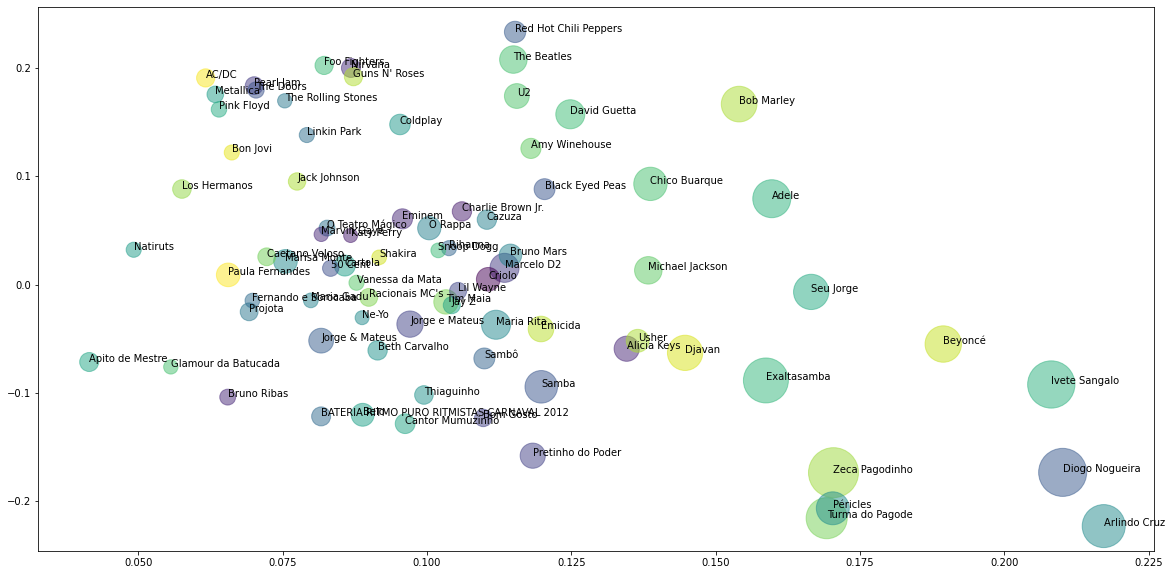

In [ ]:
N = 50
x = svd.components_[0]
y = svd.components_[1]
colors = np.random.rand(len(x))
area = (50 * music_df[:80]['count'].values / max(music_df[:80]['count'].values))**2  # 0 to 15 point radii

plt.figure(figsize=(20,10))
plt.scatter(x, y, s=area, c=colors, alpha=0.5)

for i, txt in enumerate(music_df[:80]['page']):
    plt.annotate(txt, (x[i], y[i]))

plt.show()

In [ ]:
top_pages_on_dims = [pd.DataFrame(sorted([(music_map[m], c) for m, c in enumerate(svd.components_[c])], key=lambda tup: tup[1])[-10:][::-1], columns=['page', 'weight']) for c in range(svd.components_.shape[0])]

### **Dimensions Profiling**

In [ ]:
top_pages_on_dims[0]

,page,weight
0,Arlindo Cruz,0.217235
1,Diogo Nogueira,0.210122
2,Ivete Sangalo,0.208149
3,Beyoncé,0.189436
4,Zeca Pagodinho,0.170418
5,Péricles,0.170295
6,Turma do Pagode,0.169236
7,Seu Jorge,0.166552
8,Adele,0.159722
9,Exaltasamba,0.158708


In [ ]:
top_pages_on_dims[1]

,page,weight
0,Red Hot Chili Peppers,0.233435
1,The Beatles,0.207903
2,Foo Fighters,0.202482
3,Nirvana,0.200147
4,Guns N' Roses,0.192095
5,AC/DC,0.190938
6,Pearl Jam,0.183812
7,The Doors,0.179783
8,Metallica,0.175754
9,U2,0.174239


In [ ]:
top_pages_on_dims[2]

,page,weight
0,Chico Buarque,0.252515
1,Tim Maia,0.198056
2,Djavan,0.196095
3,Cartola,0.190788
4,Maria Rita,0.190557
5,Samba,0.183570
6,Zeca Pagodinho,0.167942
7,Criolo,0.159367
8,Marisa Monte,0.156245
9,Marvin Gaye,0.143122


In [ ]:
top_pages_on_dims[3]

,page,weight
0,Ivete Sangalo,0.330048
1,Jorge & Mateus,0.254146
2,Jorge e Mateus,0.251178
3,Diogo Nogueira,0.250442
4,Fernando e Sorocaba,0.177784
5,The Beatles,0.156962
6,Paula Fernandes,0.121231
7,U2,0.117742
8,Sambô,0.104845
9,Chico Buarque,0.096606


In [ ]:
top_pages_on_dims[4]

,page,weight
0,Bob Marley,0.240023
1,Péricles,0.179856
2,Nirvana,0.159754
3,Turma do Pagode,0.159639
4,Pretinho do Poder,0.159435
5,Marcelo D2,0.157759
6,O Rappa,0.157556
7,The Doors,0.148816
8,Arlindo Cruz,0.147168
9,Metallica,0.143606


In [ ]:
top_pages_on_dims[5]

,page,weight
0,O Rappa,0.264663
1,Marcelo D2,0.260096
2,Charlie Brown Jr.,0.237306
3,Bob Marley,0.165180
4,Sambô,0.160079
5,Racionais MC's,0.159916
6,Criolo,0.156814
7,Emicida,0.139807
8,Projota,0.123546
9,David Guetta,0.120305


In [ ]:
top_pages_on_dims[6]

,page,weight
0,Turma do Pagode,0.251853
1,Pretinho do Poder,0.221913
2,Cantor Mumuzinho,0.186796
3,Chico Buarque,0.176128
4,Criolo,0.168955
5,Amy Winehouse,0.168415
6,Marisa Monte,0.152991
7,Emicida,0.142014
8,Thiaguinho,0.140542
9,Bom Gosto,0.139405


In [ ]:
top_pages_on_dims[7]

,page,weight
0,Adele,0.481850
1,Arlindo Cruz,0.251286
2,Cazuza,0.202775
3,Charlie Brown Jr.,0.173231
4,The Beatles,0.162283
5,Bruno Mars,0.161832
6,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,0.137733
7,Pretinho do Poder,0.126895
8,Cantor Mumuzinho,0.125399
9,Turma do Pagode,0.114471


In [ ]:
top_pages_on_dims[8]

,page,weight
0,Seu Jorge,0.325277
1,Jorge e Mateus,0.243354
2,David Guetta,0.208375
3,Jorge & Mateus,0.166684
4,Michael Jackson,0.165603
5,Fernando e Sorocaba,0.164684
6,Exaltasamba,0.129940
7,Djavan,0.127055
8,Diogo Nogueira,0.117728
9,Arlindo Cruz,0.106133


In [ ]:
top_pages_on_dims[9]

,page,weight
0,Chico Buarque,0.398498
1,Jorge e Mateus,0.280597
2,Eminem,0.228839
3,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,0.214465
4,Cartola,0.214064
5,Lil Wayne,0.214043
6,The Beatles,0.169368
7,Jorge & Mateus,0.158107
8,Samba,0.155432
9,Fernando e Sorocaba,0.141078


In [ ]:
top_pages_on_dims[10]

,page,weight
0,Samba,0.363211
1,Seu Jorge,0.317488
2,Beyoncé,0.201667
3,Jorge e Mateus,0.192379
4,Emicida,0.181625
5,AC/DC,0.164636
6,BATERIA RITMO PURO RITMISTAS CARNAVAL 2012,0.144843
7,Nirvana,0.139659
8,Adele,0.137039
9,Foo Fighters,0.122495


In [ ]:
top_pages_on_dims[11]

,page,weight
0,Diogo Nogueira,0.203470
1,Coldplay,0.176427
2,Lil Wayne,0.164124
3,Sambô,0.153506
4,Usher,0.148370
5,Eminem,0.138825
6,Bon Jovi,0.136788
7,50 Cent,0.131643
8,Emicida,0.123271
9,Projota,0.118109


# **Clustering**

## **Hierarquical Clustering**

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

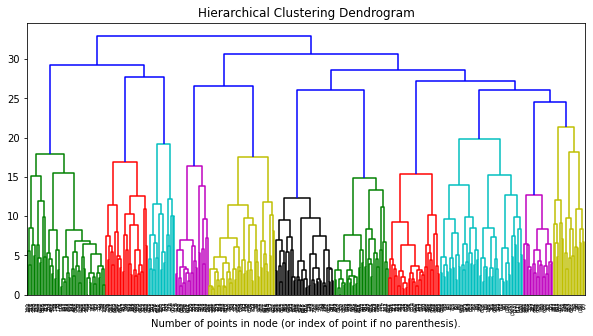

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(df_data_new)
plt.figure(figsize=(10,5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## **K-Means**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_data_new)

In [ ]:
df_cluster_data = pd.concat([df_data_new, pd.Series(kmeans.predict(df_data_new), name='cluster')], axis=1)

## **Clusters Profiling**

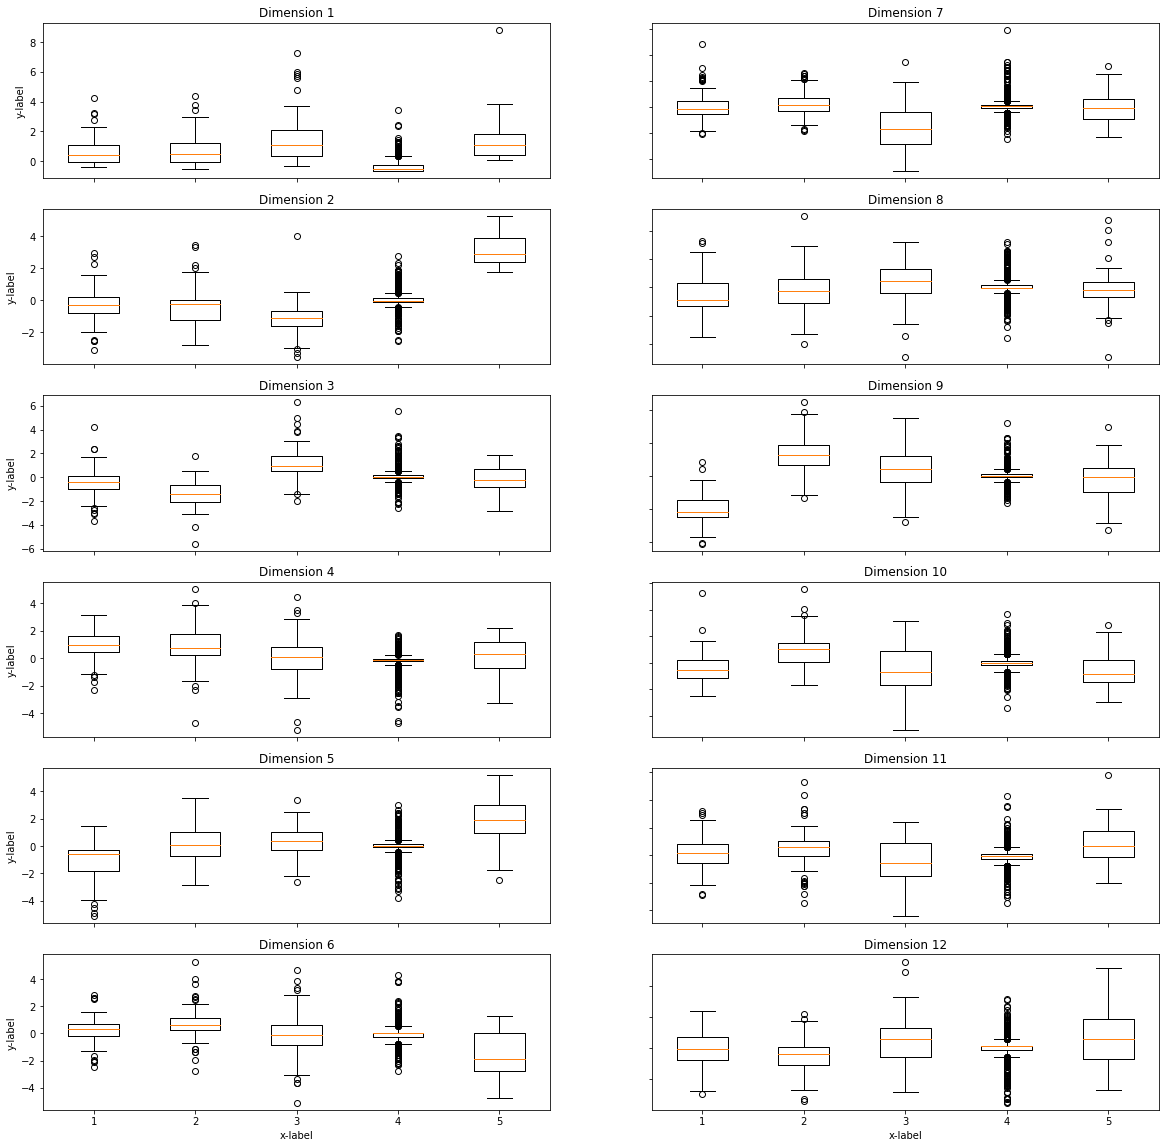

In [ ]:
fig, axs = plt.subplots(6, 2,figsize=(20,20))
for i in range(12):
  data = [df_cluster_data[df_cluster_data['cluster']==c]['Dim{}'.format(i+1)].values for c in np.unique(df_cluster_data['cluster'].values)]
  axs[i if i < 6 else i - 6, i // 6].boxplot(data)
  axs[i if i < 6 else i - 6, i // 6].set_title('Dimension {}'.format(i + 1))

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
df_cluster_data.groupby('cluster').aggregate({'Dim' + str(c+1) : np.mean for c in range(svd.components_.shape[0])})

,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10,Dim11,Dim12
cluster,,,,,,,,,,,,
0,0.614612,-0.258608,-0.410970,0.912469,-1.040946,0.245539,0.093895,-0.542341,-1.990448,-0.428653,0.166201,-0.054857
1,0.668552,-0.398975,-1.450749,0.952315,0.171469,0.724307,0.291497,-0.176061,1.377225,0.982527,0.438099,-0.451979
2,1.522577,-1.189783,1.182362,-0.095297,0.340358,-0.079747,-1.559819,0.365331,0.328359,-0.463958,-0.468305,0.463079
3,-0.358843,0.051426,0.082842,-0.204724,-0.009962,-0.025952,0.116268,0.046645,0.062141,0.015233,-0.059997,-0.016991
4,1.535881,3.213469,-0.156842,0.294828,1.771292,-1.575207,0.016657,-0.085086,-0.219552,-0.465839,1.004135,0.526126
